In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit

Cosas a estudiar

In [2]:
# Valor medio de respuesta vs. amplitud de alimentacion
# Valor medio de respuesta vs. offset de alimentacion
# Amplitud de respuesta vs. amplitud de alimentacion
# Amplitud de respuesta vs. offset de alimentacion
# frecuencia de respuesta vs. frecuencia de alimentacion

In [123]:
# Cargamos los datos
with open(f"../mediciones/Barrido fino en offsets a 1 V de amp.pickle 2", "rb") as f:
    dic = pickle.load(f)

In [124]:
# Hago una lista con los valores de offset que alimentamos con el generador de funciones
offs_values = list(dic.keys())
print(offs_values)
# Valores de corriente en mA
corr_values = [np.mean(dic[offset]["V_2"])*1000 for offset in offs_values]
print(corr_values)

['-1.0V', '-0.9V', '-0.8V', '-0.7000000000000001V', '-0.6000000000000001V', '-0.5000000000000001V', '-0.40000000000000013V', '-0.30000000000000016V', '-0.20000000000000018V', '-0.1000000000000002V', '-2.220446049250313e-16V', '0.09999999999999964V', '0.19999999999999973V', '0.2999999999999998V', '0.3999999999999997V', '0.49999999999999956V', '0.5999999999999996V', '0.6999999999999997V', '0.7999999999999996V', '0.8999999999999995V', '0.9999999999999996V', '1.0999999999999996V', '1.1999999999999993V', '1.2999999999999994V', '1.3999999999999995V', '1.4999999999999996V', '1.5999999999999996V', '1.6999999999999993V', '1.7999999999999994V', '1.8999999999999995V', '1.9999999999999991V', '2.099999999999999V', '2.1999999999999993V', '2.2999999999999994V', '2.3999999999999995V', '2.499999999999999V', '2.599999999999999V', '2.6999999999999993V', '2.799999999999999V', '2.899999999999999V']
[-358.02799999999996, -358.568, -358.83199999999994, -359.512, -359.908, -359.958, -359.658, -359.39799999999

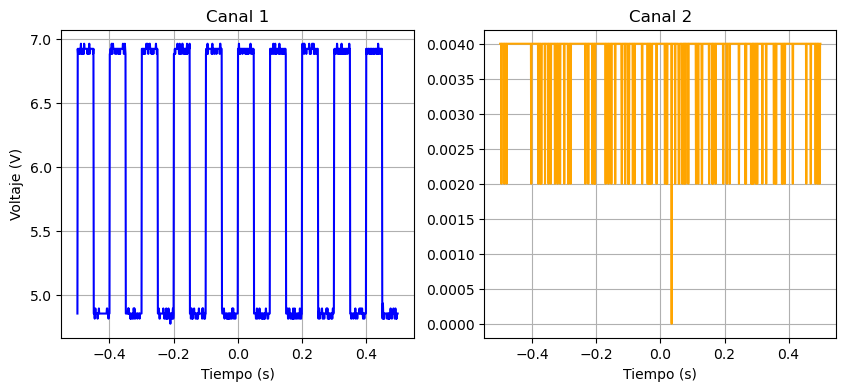

In [125]:
volt = offs_values[-1]

t_1, v_1 = dic[volt]["t_1"], dic[volt]["V_1"]
t_2, v_2 = dic[volt]["t_2"], dic[volt]["V_2"]


fig, axs = plt.subplots(ncols = 2, figsize = (10,4))
axs[0].plot(t_1,v_1, color = "b")
axs[0].set_xlabel("Tiempo (s)")
axs[1].plot(t_2,v_2, color = "orange")
axs[1].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Voltaje (V)")
axs[0].set_title("Canal 1")
axs[0].grid()
axs[1].set_title("Canal 2")
axs[1].grid()
plt.show()

# Relación entre offset seteado y offset medido

In [126]:
offs_true_values = [np.mean(dic[offset]["V_1"]) for offset in offs_values]

offs_values_new = []
for offset in offs_values:
    new_offset = offset[:-1]
    offs_values_new.append(float(new_offset))

print("Valores del generador",offs_values_new)
#print("Valores Viejos", offs_values)
#print("Valores medidos", offs_true_values)

Valores del generador [-1.0, -0.9, -0.8, -0.7000000000000001, -0.6000000000000001, -0.5000000000000001, -0.40000000000000013, -0.30000000000000016, -0.20000000000000018, -0.1000000000000002, -2.220446049250313e-16, 0.09999999999999964, 0.19999999999999973, 0.2999999999999998, 0.3999999999999997, 0.49999999999999956, 0.5999999999999996, 0.6999999999999997, 0.7999999999999996, 0.8999999999999995, 0.9999999999999996, 1.0999999999999996, 1.1999999999999993, 1.2999999999999994, 1.3999999999999995, 1.4999999999999996, 1.5999999999999996, 1.6999999999999993, 1.7999999999999994, 1.8999999999999995, 1.9999999999999991, 2.099999999999999, 2.1999999999999993, 2.2999999999999994, 2.3999999999999995, 2.499999999999999, 2.599999999999999, 2.6999999999999993, 2.799999999999999, 2.899999999999999]


In [127]:
def lineal(x, a, b): return a*x+b

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(lineal, offs_values_new, offs_true_values)

# Imprimo en pantalla los valores de popt y pcov
a, b = popt
err_a, err_b = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'a: {a} ± {err_a}')
print(f'b: {b} ± {err_b}')

Los parametros de ajuste son:
a: 1.9974711246284145 ± 0.01282689331282676
b: 0.0624589036467571 ± 0.019176095478120013


Hay diferencias recién en la 3ra y 4ta cifra significativa.

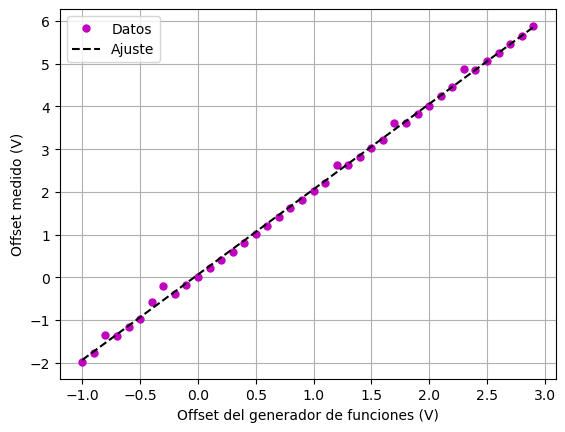

In [18]:
plt.plot(offs_values_new, offs_true_values, ".m",ms = 10, label = "Datos")
plt.plot(offs_values_new, lineal(np.array(offs_values_new),a,b), "--k", label = "Ajuste")
plt.xlabel("Offset del generador de funciones (V)")
plt.ylabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()

# Relación entre offset de la alimentación y valor medio de corriente medido

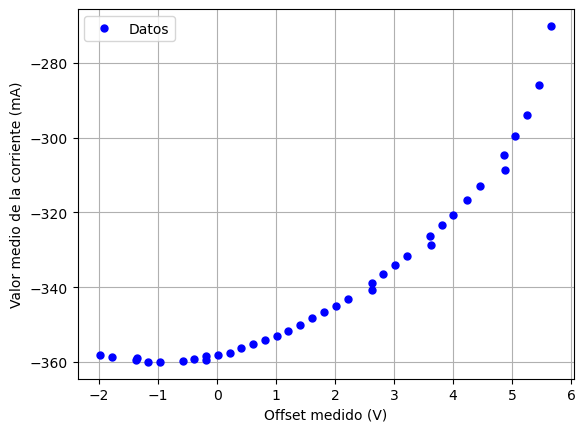

In [128]:
plt.plot(offs_true_values[:-1], corr_values[:-1],".b", ms = 10, label = "Datos")
#plt.plot(offs_true_values[:], corr_values[:],".b", ms = 10, label = "Datos")
plt.ylabel("Valor medio de la corriente (mA)")
plt.xlabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()

In [68]:
# Ajuste cuadrático
def cuad(x, A, B, C): return A*x**2 + B*x + C

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(cuad, offs_true_values[:-1], corr_values[:-1])

# Imprimo en pantalla los valores de popt y pcov
A, B, C = popt
err_A, err_B, err_C = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'A: {A} ± {err_A}')
print(f'B: {B} ± {err_B}')
print(f'C: {C} ± {err_C}')

cuadratica = cuad(np.array(offs_true_values[:-1]),A,B,C)

Los parametros de ajuste son:
A: 1.91273179322735 ± 0.10713307242504397
B: 2.43901476042389 ± 0.4571249750210293
C: -358.86979580042595 ± 0.6494152639475252


In [70]:
# Ajuste exponencial
def exp(x, Amp, frec, ord): return Amp*np.exp(frec*x) + ord

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(exp, offs_true_values[:-1], corr_values[:-1])

# Imprimo en pantalla los valores de popt y pcov
A, B, C = popt
err_A, err_B, err_C = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'A: {A} ± {err_A}')
print(f'B: {B} ± {err_B}')
print(f'C: {C} ± {err_C}')


exponencial = exp(np.array(offs_true_values[:-1]),A,B,C)

Los parametros de ajuste son:
A: 7.786665488435747 ± 0.8641011073705228
B: 0.4260938771320389 ± 0.019160953798741758
C: -364.35656636732676 ± 1.1522891487426434


In [ ]:
plt.plot(offs_true_values[:-2], corr_values[:-2],".b", ms = 10, label = "Datos")
plt.plot(offs_true_values[:-2], cuadratica, "--k", label = "Ajuste cuadrático")
plt.plot(offs_true_values[:-2], exponencial, "--g", label = "Ajuste exponencial")
plt.ylabel("Valor medio de la corriente (mA)")
plt.xlabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()

## Diferencia de R²

In [ ]:
# Hay que modificarlo pero es usable
residuos_cuad = corr_values[:-2] - cuad(offs_true_values[:-2], A, B, C)
ss_res = np.sum(residuos_cuad**2)
ss_tot = np.sum((corr_values[:-2] -np.mean(corr_values[:-2]))**2)
r_2_cuad = 1 - (ss_res / ss_tot)
print(f"El r² cuadrado del ajuste cuadrático es es {r_2_cuad}")
residuos_exp = corr_values[:-2] - exp(offs_true_values[:-2], A, B, C)
ss_res = np.sum(residuos_exp**2)
ss_tot = np.sum((corr_values[:-2] -np.mean(corr_values[:-2]))**2)
r_2_exp = 1 - (ss_res / ss_tot)
print(f"El r² cuadrado del ajuste exponencial es {r_2_exp}")
print(f"La diferencia entre r² es {r_2_exp-r_2_cuad}")

# Barrido en amplitud

In [103]:
volt = amp_values[-1]

condicion_maximo_1 = np.where(dic[volt]["V_1"]> np.mean(dic[volt]["V_1"]))
lista_maximos_1 = dic[volt]["V_1"][condicion_maximo_1]
tiempos_maximos_1 = dic[volt]["t_1"][condicion_maximo_1]

condicion_maximo_2 = np.where(dic[volt]["V_2"] > np.mean(dic[volt]["V_2"]))
lista_maximos_2 = dic[volt]["V_2"][condicion_maximo_2]
tiempos_maximos_2 = dic[volt]["t_2"][condicion_maximo_2]


condicion_minimo_2 = np.where(dic[volt]["V_2"] < np.mean(dic[volt]["V_2"]))
lista_minimos_2 = dic[volt]["V_2"][condicion_minimo_2]
tiempos_minimos_2 = dic[volt]["t_2"][condicion_minimo_2]

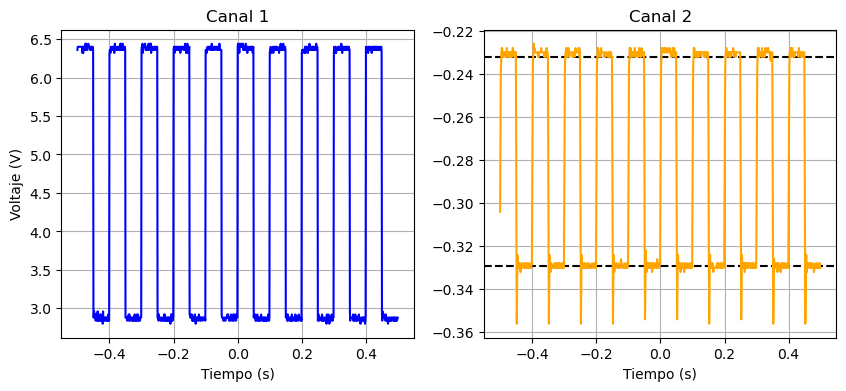

In [104]:
t_1, v_1 = dic[volt]["t_1"], dic[volt]["V_1"]
t_2, v_2 = dic[volt]["t_2"], dic[volt]["V_2"]


fig, axs = plt.subplots(ncols = 2, figsize = (10,4))
axs[1].axhline(np.mean(lista_maximos_2), ls = "--", c = "k")
axs[1].axhline(np.mean(lista_minimos_2), ls = "--", c = "k")

axs[0].plot(t_1,v_1, color = "b")
axs[0].set_xlabel("Tiempo (s)")
axs[1].plot(t_2,v_2, color = "orange")
axs[1].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Voltaje (V)")
axs[0].set_title("Canal 1")
axs[0].grid()
axs[1].set_title("Canal 2")
axs[1].grid()

plt.show()


In [111]:
lista_amp_alim = []
lista_amp_corr = []

for amp in amp_values:
    
    # Calculamos la amplitud de la cuadrada con la que alimentamos
    condicion_maximo_1 = np.where(dic[amp]["V_1"]> np.mean(dic[amp]["V_1"]))
    lista_maximos_1 = dic[amp]["V_1"][condicion_maximo_1]
    tiempos_maximos_1 = dic[amp]["t_1"][condicion_maximo_1]
    
    condicion_minimo_1 = np.where(dic[amp]["V_1"] < np.mean(dic[amp]["V_1"]))
    lista_minimos_1 = dic[amp]["V_1"][condicion_minimo_1]
    tiempos_minimos_1 = dic[amp]["t_1"][condicion_minimo_1]
    
    # Calculamos la amplitud del generador de corriente
    condicion_maximo_2 = np.where(dic[amp]["V_2"] > np.mean(dic[amp]["V_2"]))
    lista_maximos_2 = dic[amp]["V_2"][condicion_maximo_2]
    tiempos_maximos_2 = dic[amp]["t_2"][condicion_maximo_2]

    condicion_minimo_2 = np.where(dic[amp]["V_2"] < np.mean(dic[amp]["V_2"]))
    lista_minimos_2 = dic[amp]["V_2"][condicion_minimo_2]
    tiempos_minimos_2 = dic[amp]["t_2"][condicion_minimo_2]
    
    amp_alim = np.mean(lista_maximos_1)-np.mean(lista_minimos_1)
    amp_corr = np.mean(lista_maximos_2)-np.mean(lista_minimos_2)
    
    lista_amp_alim.append(amp_alim) 
    lista_amp_corr.append(amp_corr*1000) # Lo pasamos a mA
    

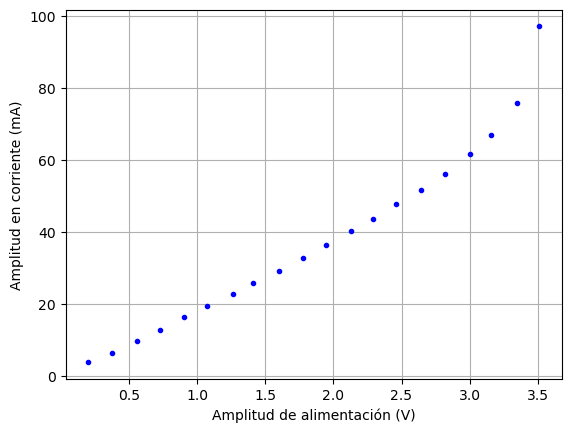

In [114]:
plt.plot(lista_amp_alim[:],lista_amp_corr[:],".", c = "b")
plt.xlabel("Amplitud de alimentación (V)")
plt.ylabel("Amplitud en corriente (mA)")
plt.grid()
plt.show()

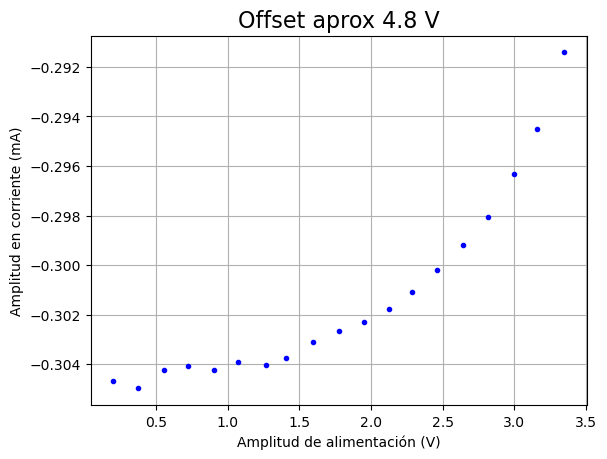

In [121]:
lista_corr_med = [np.mean(dic[amp]["V_2"]) for amp in amp_values]

plt.plot(lista_amp_alim[:-1],lista_corr_med[:-1],".", c = "b")
plt.title("Offset aprox 4.8 V", fontsize = 16)
plt.xlabel("Amplitud de alimentación (V)")
plt.ylabel("Amplitud en corriente (mA)")
plt.grid()
plt.show()

In [73]:
# Cargamos los datos
with open(f"../mediciones/Barrido en amplitud a 2.4 V de offset.pickle", "rb") as f:
    dic = pickle.load(f)

In [75]:
# Hago una lista con los valores de offset que alimentamos con el generador de funciones
amp_values = list(dic.keys())
print(offs_values)
# Valores de corriente en mA
corr_values = [np.mean(dic[amp]["V_2"])*1000 for amp in amp_values]
print(corr_values)

['-1.0V', '-0.9V', '-0.8V', '-0.7000000000000001V', '-0.6000000000000001V', '-0.5000000000000001V', '-0.40000000000000013V', '-0.30000000000000016V', '-0.20000000000000018V', '-0.1000000000000002V', '-2.220446049250313e-16V', '0.09999999999999964V', '0.19999999999999973V', '0.2999999999999998V', '0.3999999999999997V', '0.49999999999999956V', '0.5999999999999996V', '0.6999999999999997V', '0.7999999999999996V', '0.8999999999999995V', '0.9999999999999996V', '1.0999999999999996V', '1.1999999999999993V', '1.2999999999999994V', '1.3999999999999995V', '1.4999999999999996V', '1.5999999999999996V', '1.6999999999999993V', '1.7999999999999994V', '1.8999999999999995V', '1.9999999999999991V', '2.099999999999999V', '2.1999999999999993V', '2.2999999999999994V', '2.3999999999999995V', '2.499999999999999V', '2.599999999999999V', '2.6999999999999993V', '2.799999999999999V', '2.899999999999999V']
[-304.66999999999996, -304.97599999999994, -304.214, -304.054, -304.24, -303.916, -304.03599999999994, -303.7

In [76]:
amp_values_new = []
for amp in amp_values:
    new_amp = amp[:-1]
    amp_values_new.append(float(new_amp))

print("Valores del generador", amp_values_new)

Valores del generador [0.1, 0.1842105263157895, 0.26842105263157895, 0.3526315789473684, 0.4368421052631579, 0.5210526315789473, 0.6052631578947368, 0.6894736842105262, 0.7736842105263158, 0.8578947368421053, 0.9421052631578947, 1.0263157894736843, 1.1105263157894738, 1.1947368421052633, 1.2789473684210526, 1.3631578947368421, 1.4473684210526316, 1.5315789473684212, 1.6157894736842107, 1.7]


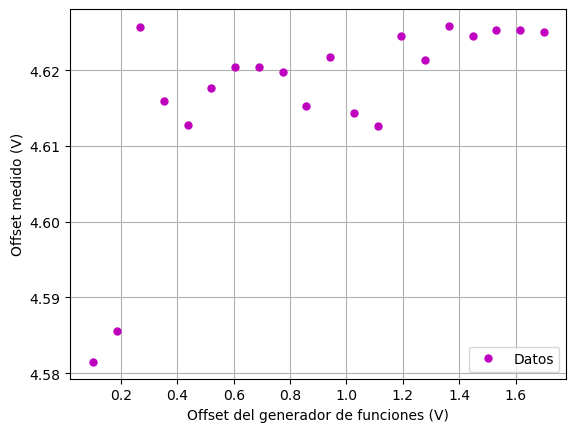

In [77]:
plt.plot(amp_values_new, amp_true_values, ".m",ms = 10, label = "Datos")
#plt.plot(amp_values_new, lineal(np.array(offs_values_new),a,b), "--k", label = "Ajuste")
plt.xlabel("Offset del generador de funciones (V)")
plt.ylabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()